In [1]:
import jax.numpy as jnp


In [2]:
def get_cell_coord(x):
    ix = jnp.floor(x)
    return x - ix, ix


def cic(x, y, z, Nx: int, Ny: int, Nz: int, Lx, Ly, Lz):
    Ntot = Nx * Ny * Nz
    x = x * Nx / Lx
    y = y * Ny / Ly
    z = z * Nz / Lz

    qx, ix = get_cell_coord(x)
    qy, iy = get_cell_coord(y)
    qz, iz = get_cell_coord(z)

    ix = ix.astype(int)
    iy = iy.astype(int)
    iz = iz.astype(int)
    rx = 1.0 - qx
    ry = 1.0 - qy
    rz = 1.0 - qz
    jx = (ix + 1) % Nx
    jy = (iy + 1) % Ny
    jz = (iz + 1) % Nz

    rho = jnp.zeros((Ntot,))

    for a in [False, True]:
        for b in [False, True]:
            for c in [False, True]:
                ax = jx if a else ix
                ay = jy if b else iy
                az = jz if c else iz
                ux = qx if a else rx
                uy = qy if b else ry
                uz = qz if c else rz

                idx = az + Nz * ay + Nz * Ny * ax
                rho += jnp.bincount(idx, weights=ux * uy * uz, length=Ntot)

    return rho.reshape((Nx, Ny, Nz)) / (x.shape[0] / Ntot) - 1.0




In [3]:
import numpy as np
import sys,os
import readgadget
import MAS_library as MASL

# This routine computes the density field and save results to file
def compute_df(snapshot, ptypes, grid, fout):
    # if not(os.path.exists(snapshot+'.0')) and not(os.path.exists(snapshot+'.0.hdf5')):
        # return 0
    print(snapshot)
    df = MASL.density_field_gadget(snapshot, ptypes, grid, MAS='CIC',
                                   do_RSD=False, axis=0, verbose=True)
    df = df/np.mean(df, dtype=np.float64)-1.0
    np.save(fout, df)
    
    
    


In [4]:
# %pip install Pylians


In [5]:
# %pip install Pylians
root         = '/pscratch/sd/s/spandey/quijote/Snapshot_fid'
root_out     = '/pscratch/sd/s/spandey/quijote/Snapshot_fid/Snapshot_fid_density'
ptypes       = [1]
snapnum      = 0
grid         = 128
# numbers = np.arange(0,17)
# for i in numbers:
i = 0
print(i)
# for snapnum in [0,1,2,3,4]:
snapnum = 4
print(snapnum)
# find the redshift
z = {4:0, 3:0.5, 2:1, 1:2, 0:3}[snapnum]

# create output folder if it does not exists
folder_out = '%s/%d'%(root_out,i)
if not(os.path.exists(folder_out)):
    os.system('mkdir %s'%folder_out)

# find name of output file
fout = '%s/df_m_%d_z=%s.npy'%(folder_out,grid,z)
# if os.path.exists(fout):  continue

# compute the density field and save it to file
snapshot = '%s/%d/snapdir_%03d/snap_%03d'%(root,i,snapnum,snapnum)
df = MASL.density_field_gadget(snapshot, ptypes, grid, MAS='CIC',
                               do_RSD=False, axis=0, verbose=True)
df_pylians = df/np.mean(df, dtype=np.float64)-1.0

# compute_df(snapshot, ptypes, grid, fout)



0
4

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.20 seconds


In [6]:
df_nbkit = {}
pos_all = (readgadget.read_block(snapshot, "POS ", [1]))/1e3
# df_nbkit['Position'] = pos_all/1e3




In [7]:
pos_all.shape


(134217728, 3)

In [8]:
# !module load cudatoolkit
# !module load cudnn



In [9]:
# %pip install jax[cuda] -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html


In [10]:
df_simon = cic(jnp.array(pos_all[:,0]), jnp.array(pos_all[:,1]), jnp.array(pos_all[:,2]), grid, grid, grid, 1e3, 1e3, 1e3)




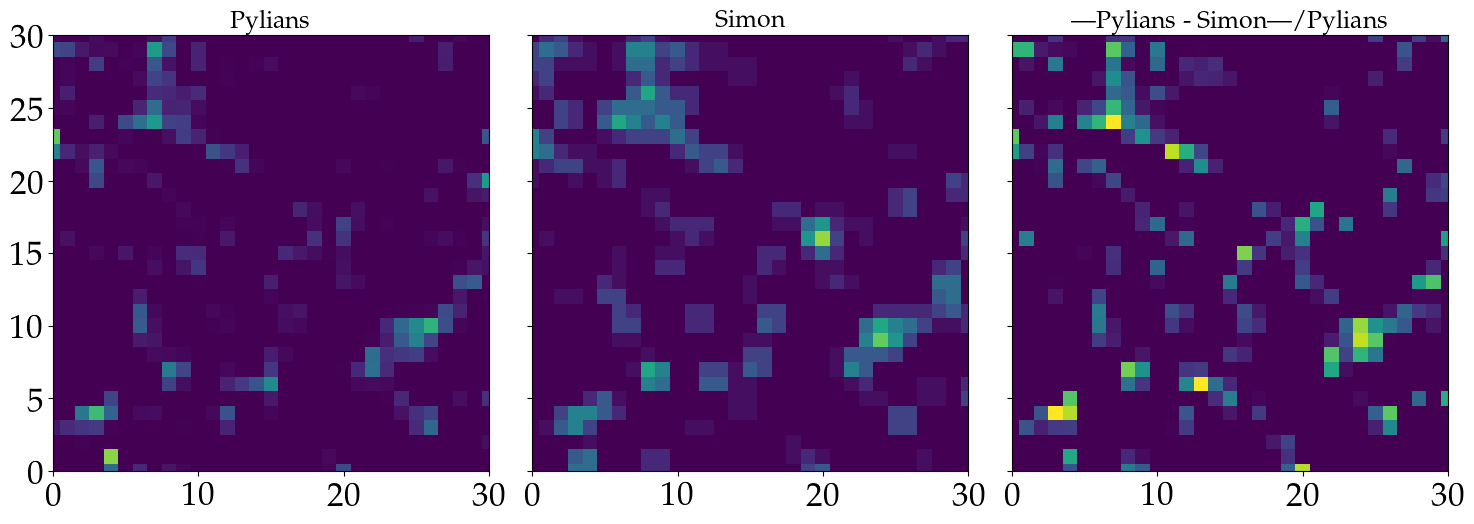

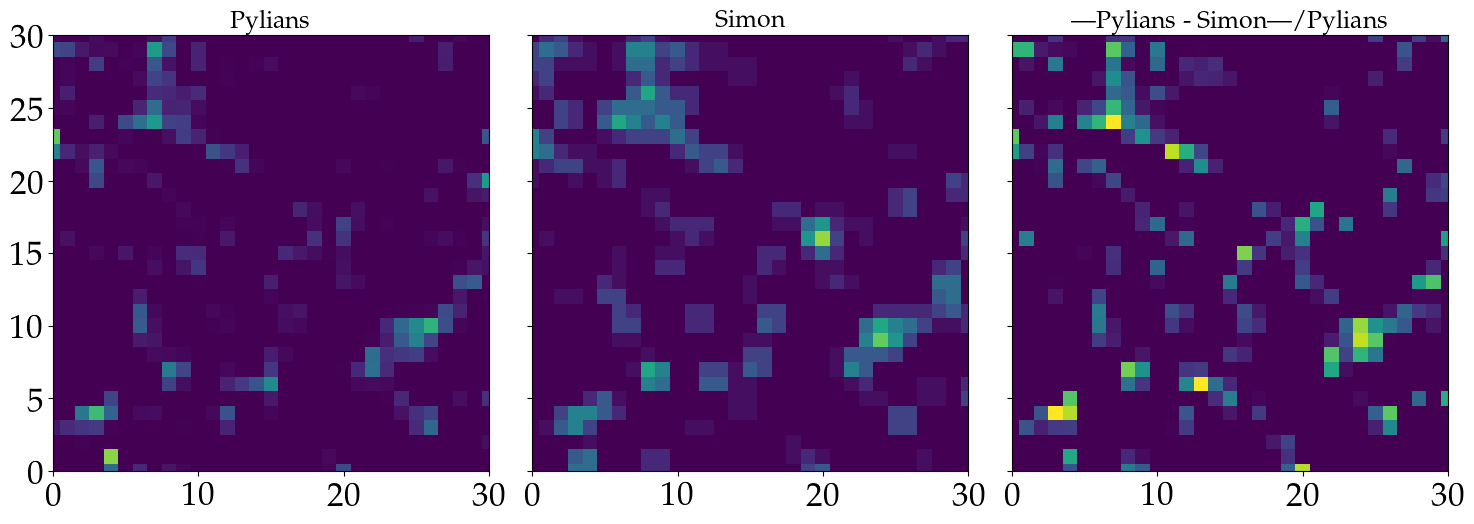

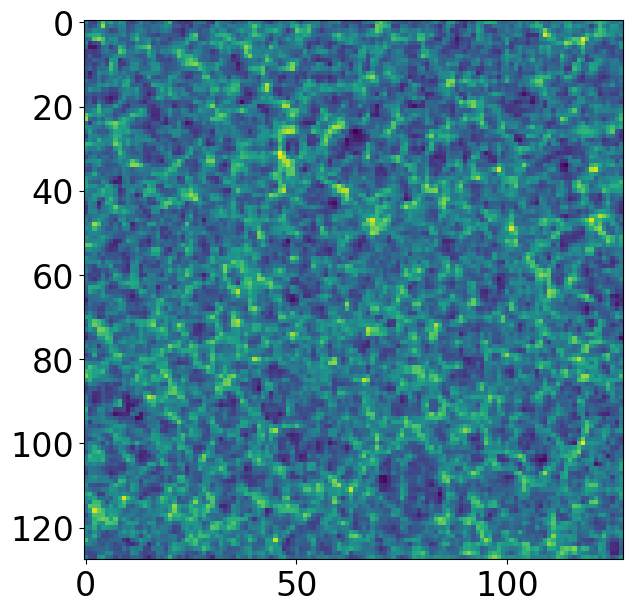

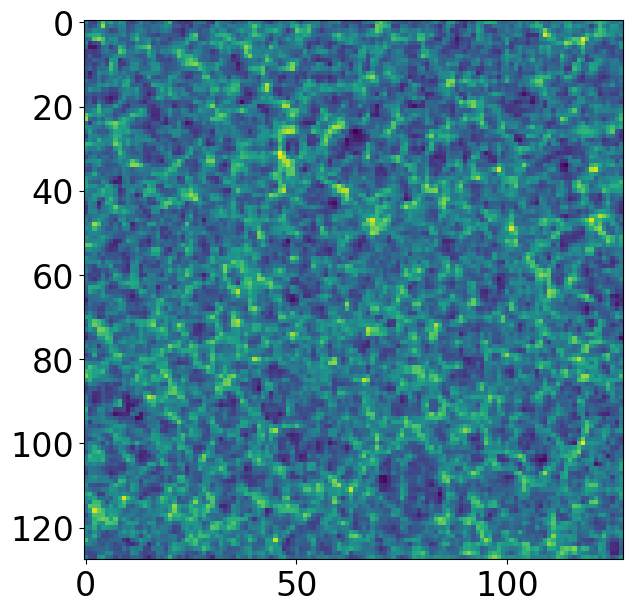

In [15]:
# df_simon.shape
import matplotlib
%matplotlib inline
import matplotlib.pyplot as pl
pl.rc('text', usetex=False)
# Palatino
pl.rc('font', family='DejaVu Sans')


pl.figure()
pl.imshow(np.log(1.0001 + df_pylians[64,:,:]))
pl.figure()
pl.imshow(np.log(1.0001 + df_simon[64,:,:]))




(0.0, 30.0)

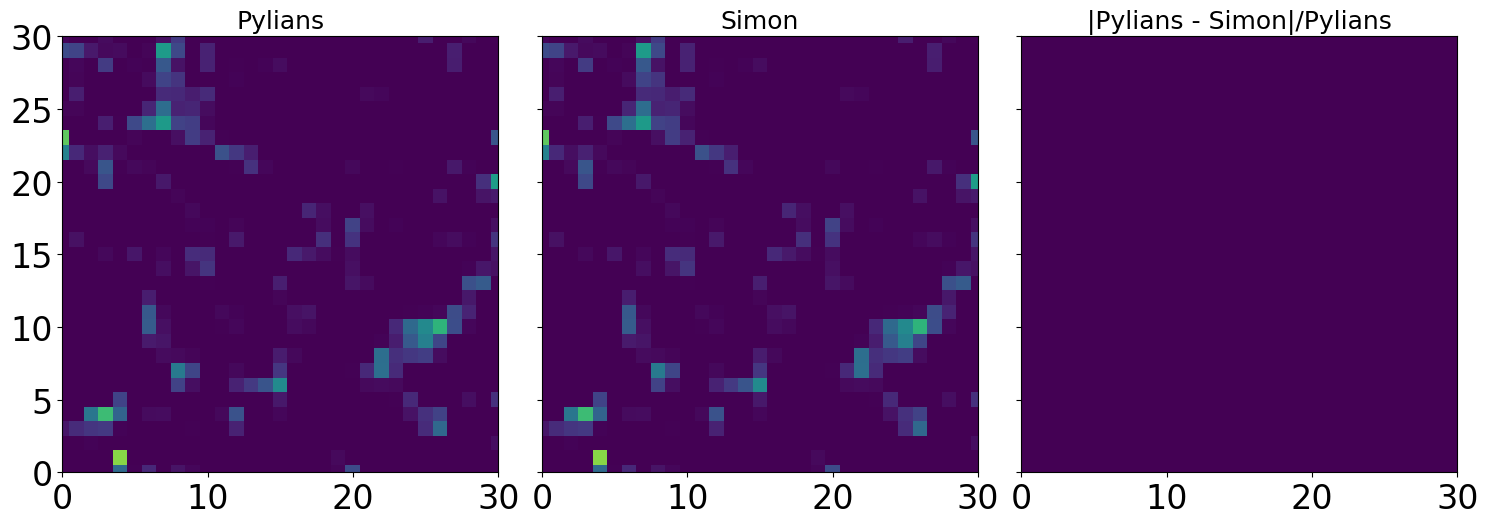

In [31]:
# Nhalos_truth_recomb.shape
# pl.figure()
# pl.imshow(np.log(np.abs(M_halos_truth_recomb[64,:,:,0] - M_halos[64,:,:,0])), origin='lower')
# # pl.imshow(np.log(np.abs(M_halos_truth_recomb[64,:,:,0] - M_halos[64,:,:,0])), origin='lower')
# pl.imshow(M_halos_truth_recomb[64,:,:,0], vmin=13, vmax=16, origin='lower')
# pl.figure()
# pl.imshow(, vmin=13, vmax=16, origin='lower')


fig, axes = pl.subplots(nrows=1, ncols=3, figsize=(18, 8), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.1)

# axes[0].imshow(((mesh_truth.preview(axes=[0,1]))))
# axes[0].set_title('Truth', size=18)
xmin = 0
xmax = 30
axes[0].imshow(df_pylians[64,:,:], vmin=0, vmax=8, origin='lower')
axes[0].set_title('Pylians', size=18)
axes[0].set_xlim(xmin,xmax)
axes[0].set_ylim(xmin,xmax)

axes[1].imshow(df_simon[64,:,:], vmin=0, vmax=8, origin='lower')
axes[1].set_title('Simon', size=18)
axes[1].set_xlim(xmin,xmax)
axes[1].set_ylim(xmin,xmax)

# axes[2].imshow((np.abs(10**M_halos_truth_recomb[64,:,:,0] - 10**M_halos[64,:,:,0])/10**M_halos_truth_recomb[64,:,:,0]), vmin=0, vmax=1.0, origin='lower')
axes[2].imshow((np.abs(df_pylians[64,:,:] - df_simon[64,:,:])/df_pylians[64,:,:]), vmin=0, vmax=1, origin='lower')
axes[2].set_title('|Pylians - Simon|/Pylians', size=18)
axes[2].set_xlim(xmin,xmax)
axes[2].set_ylim(xmin,xmax)






            

In [11]:
import readfof
import MAS_library as MASL
snap_dir_base='/pscratch/sd/s/spandey/quijote/Halos/fiducial'
snapdir = snap_dir_base + '/' + str(0)  #folder hosting the catalogue
snapnum=4
FoF = readfof.FoF_catalog(snapdir, snapnum, long_ids=False, swap=False, SFR=False, read_IDs=False)

# get the properties of the halos
pos_h_truth = FoF.GroupPos / 1e3  #Halo positions in Mpc/h
mass_truth = FoF.GroupMass * 1e10  #Halo masses in Msun/h

lgMass_truth = np.log10(mass_truth)

Mmin_Pk, Mmax_Pk = 0, 100.0
indsel_Pk_truth = np.where((lgMass_truth > Mmin_Pk) & (lgMass_truth < Mmax_Pk))[0]
print(len(indsel_Pk_truth))
# density field parameters
grid    = grid    #the 3D field will have grid x grid x grid voxels
BoxSize = 1000.0 #Mpc/h ; size of box
MAS     = 'CIC'  #mass-assigment scheme
verbose = True   #print information on progress
pos_halos = pos_h_truth[indsel_Pk_truth,...]

dfhalo_simon = cic(jnp.array(pos_halos[:,0]), jnp.array(pos_halos[:,1]), jnp.array(pos_halos[:,2]), grid, grid, grid, 1e3, 1e3, 1e3)



406660


In [20]:
# dfhalo2_ngp


(0.0, 30.0)

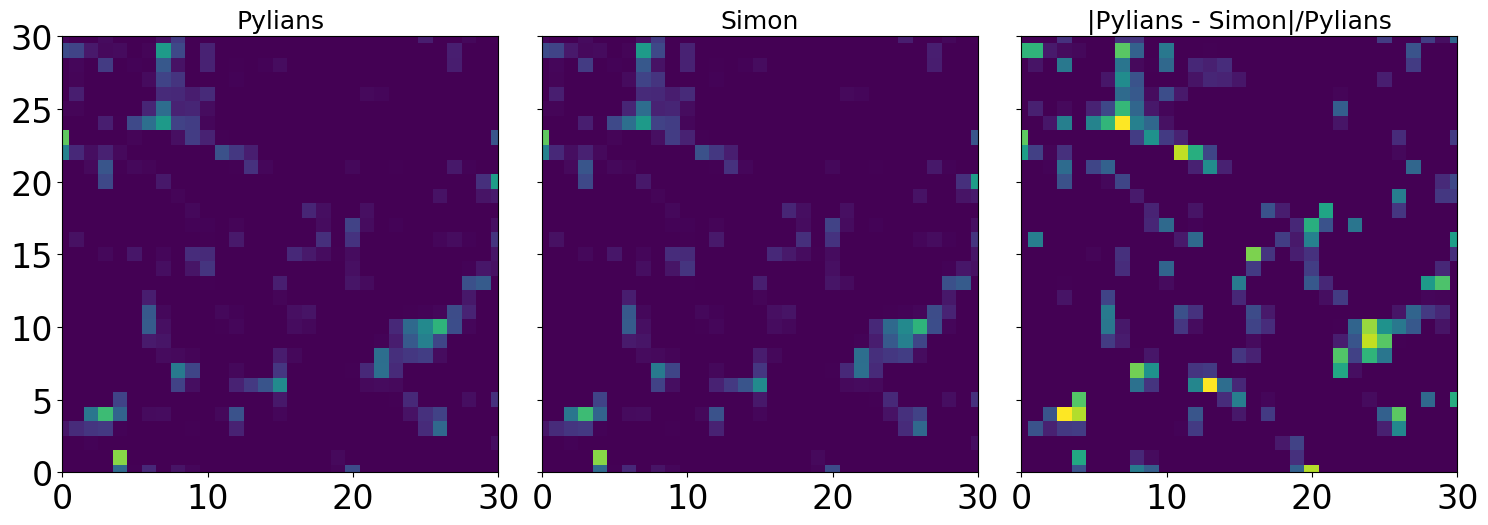

In [35]:
fig, axes = pl.subplots(nrows=1, ncols=3, figsize=(18, 8), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.1)

# axes[0].imshow(((mesh_truth.preview(axes=[0,1]))))
# axes[0].set_title('Truth', size=18)
xmin = 0
xmax = 30
axes[0].imshow(df_pylians[64,:,:], vmin=0, vmax=8, origin='lower')
axes[0].set_title('Pylians', size=18)
axes[0].set_xlim(xmin,xmax)
axes[0].set_ylim(xmin,xmax)

axes[1].imshow(df_simon[64,:,:], vmin=0, vmax=8, origin='lower')
axes[1].set_title('Simon', size=18)
axes[1].set_xlim(xmin,xmax)
axes[1].set_ylim(xmin,xmax)

# axes[2].imshow((np.abs(10**M_halos_truth_recomb[64,:,:,0] - 10**M_halos[64,:,:,0])/10**M_halos_truth_recomb[64,:,:,0]), vmin=0, vmax=1.0, origin='lower')
axes[2].imshow(dfhalo_simon[64,:,:], vmin=0, vmax=8, origin='lower')
axes[2].set_title('|Pylians - Simon|/Pylians', size=18)
axes[2].set_xlim(xmin,xmax)
axes[2].set_ylim(xmin,xmax)






            



In [12]:
import numpy as np
import h5py as h5
df = h5.File('/global/cfs/cdirs/lsst/www/shivamp/AR_NPE/run_models/truth_halo_ns128.h5', 'r')
pos_h_truth = np.vstack((df['x_h'][()],df['y_h'][()],df['z_h'][()])).T
lgMass_truth = df['lgMass_mock'][()]
dfhalo2_simon = cic(jnp.array(pos_h_truth[:,0]), jnp.array(pos_h_truth[:,1]), jnp.array(pos_h_truth[:,2]), grid, grid, grid, 1e3, 1e3, 1e3)




In [33]:
dfhalo2_ngp = np.float32(np.zeros((grid, grid, grid)))
MASL.NGP(np.float32(pos_halos), dfhalo2_ngp, 1e3)




(0.0, 10.0)

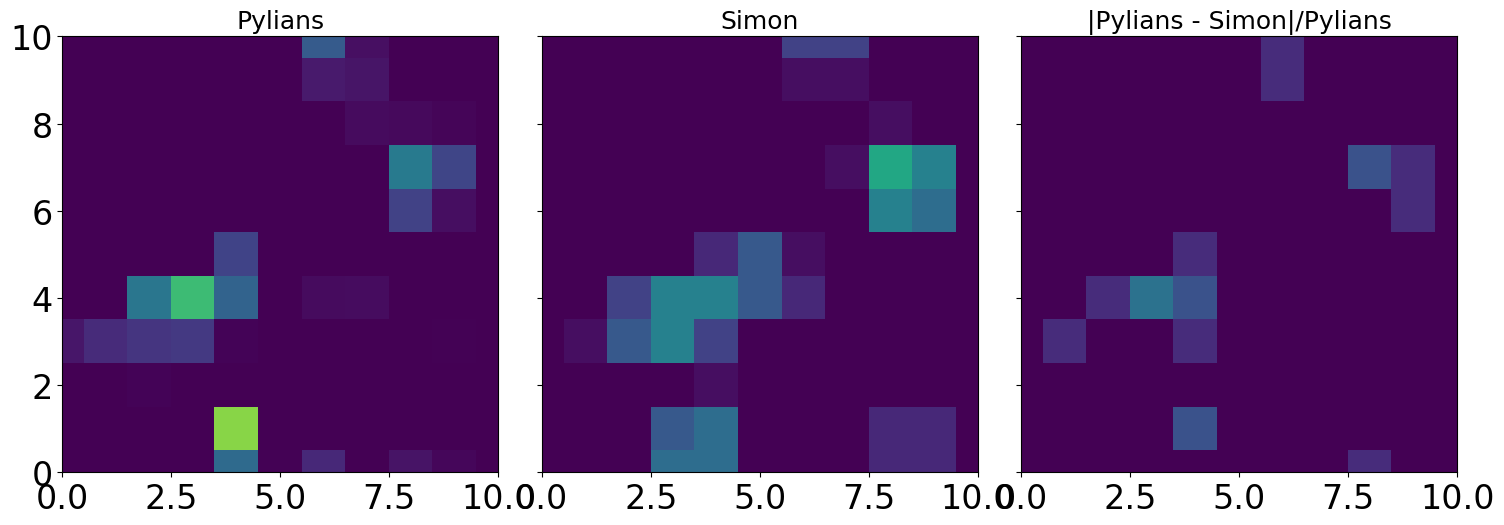

In [35]:
fig, axes = pl.subplots(nrows=1, ncols=3, figsize=(18, 8), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.1)

# axes[0].imshow(((mesh_truth.preview(axes=[0,1]))))
# axes[0].set_title('Truth', size=18)
xmin = 0
xmax = 10
axes[0].imshow(df_pylians[64,:,:], vmin=0, vmax=8, origin='lower')
axes[0].set_title('Pylians', size=18)
axes[0].set_xlim(xmin,xmax)
axes[0].set_ylim(xmin,xmax)

axes[1].imshow(dfhalo2_simon[64,:,:], vmin=0, vmax=8, origin='lower')
axes[1].set_title('Simon', size=18)
axes[1].set_xlim(xmin,xmax)
axes[1].set_ylim(xmin,xmax)

# axes[2].imshow((np.abs(10**M_halos_truth_recomb[64,:,:,0] - 10**M_halos[64,:,:,0])/10**M_halos_truth_recomb[64,:,:,0]), vmin=0, vmax=1.0, origin='lower')
axes[2].imshow(dfhalo2_ngp[64,:,:], vmin=0, vmax=8, origin='lower')
axes[2].set_title('|Pylians - Simon|/Pylians', size=18)
axes[2].set_xlim(xmin,xmax)
axes[2].set_ylim(xmin,xmax)






            



Array([-0.3553632 , -0.3553632 , -1.        , -1.        , -1.        ,
       -0.3553589 , -0.35535765, -1.        , -1.        , -1.        ],      dtype=float32)